The project is based on the data from:
https://www.kaggle.com/uciml/forest-cover-type-dataset

It is a classification problem.

In [1]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.base import clone
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from confusion import pretty_plot_confusion_matrix #this is from my local computer
import math

In [2]:
data=pd.read_csv('covtype.csv')

In [3]:
# Extracting all numerical features from data
num_fea = data.iloc[:, :10]

# extracting all binary features from data
binary_fea = data.iloc[:, 10:-1]

Our target is 'Cover_Type' and it has 7 classes. It is very imbalanced!

# Modeling

For an imbalanced data, depending on the business problem, we need to ask
1. Is it important to have a high overall accuracy, sacrificing low accuracy for  some classes
2. or some classes are more important and we need to take care of those classes and make sure that they have  higher accuracy

For this problem, we first do downsampling  to creat
a balanced data. Then we  split the data into train, test set.

In [4]:
min_num_class = min(data['Cover_Type'].value_counts())

In [5]:
balanced_data=data.groupby('Cover_Type',as_index = False,group_keys=False).apply(lambda s: s.sample(min_num_class,replace=False))


In [6]:
train,test = train_test_split(balanced_data,test_size=0.2,random_state=999)

In [7]:
train.shape

(15383, 55)

In [8]:
test.shape

(3846, 55)

In [9]:
feat_labels = list(data.columns)[0:54]

In [10]:
x_train = train[feat_labels]
y_train = train['Cover_Type']
x_test = test[feat_labels]
y_test = test['Cover_Type']

## Simple Decision Tree Classifier
We first train decision tree.

In [11]:
clf = DecisionTreeClassifier(max_depth=3,random_state=0)

In [12]:
clf = clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.5738429537181488

In [14]:
confusion =pd.DataFrame(confusion_matrix(y_test, y_pred), columns=range(1,8), index=range(1,8))

<Figure size 720x504 with 0 Axes>

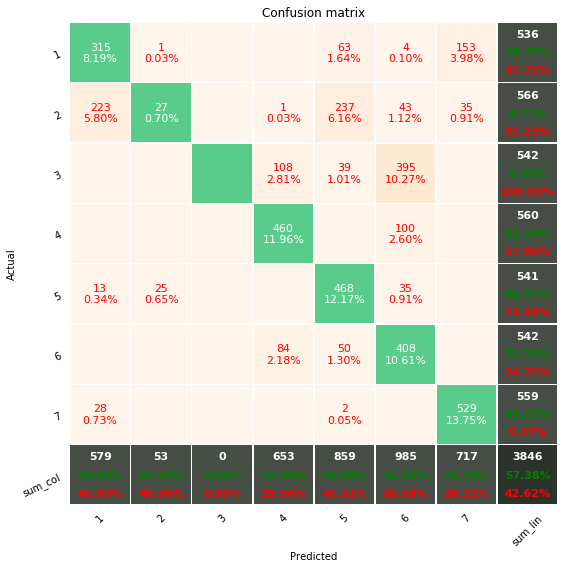

In [15]:
plt.figure(figsize = (10,7))
pretty_plot_confusion_matrix(confusion.transpose())

As we see above, the decision tree classfier is not doing well specially on predicting Cover_Type 2, correctly.
Let's visualize the tree:

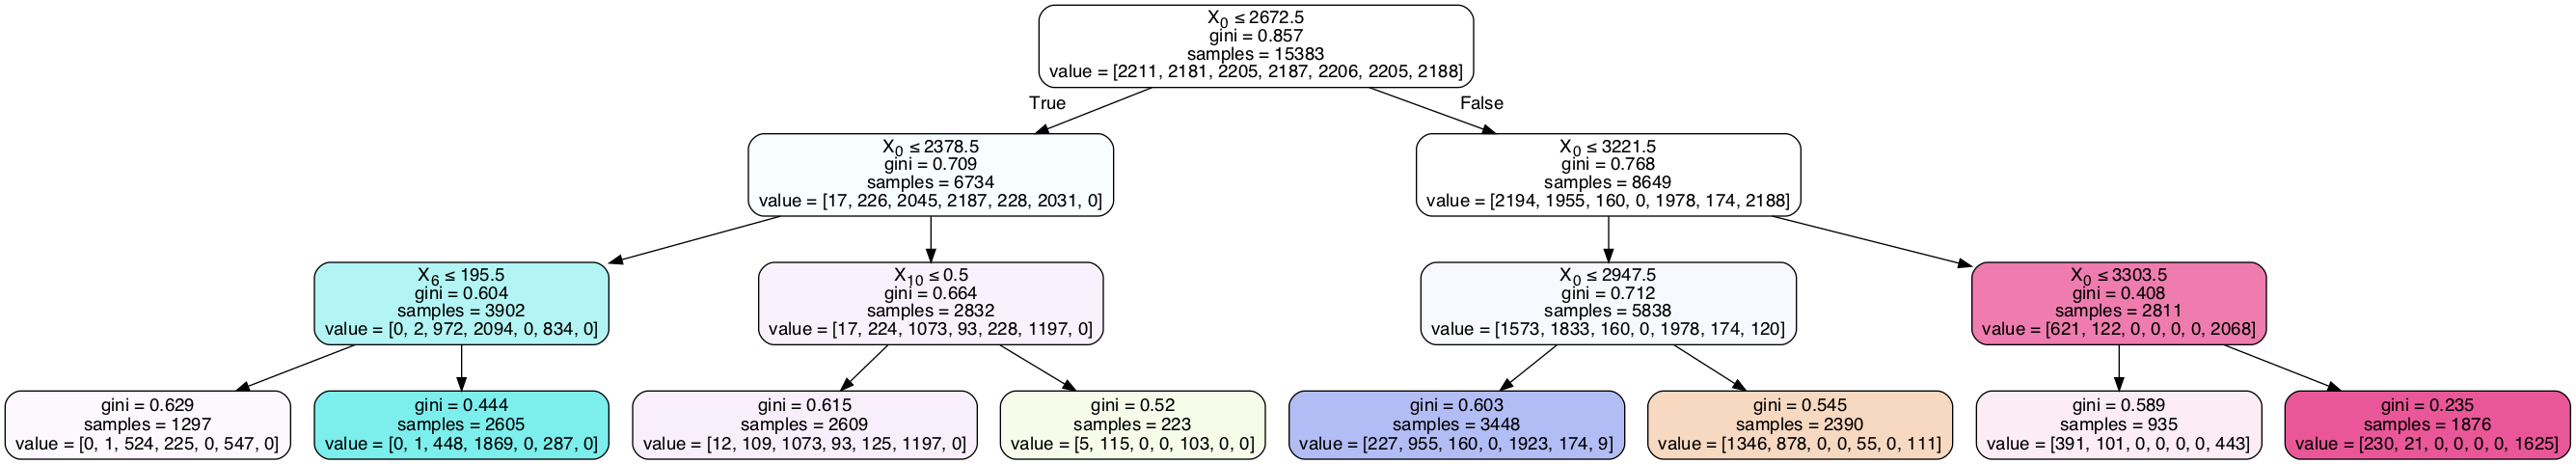

In [16]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Random Forest Classifier
Let's now look at the Random Forest Classifier with 20 trees.

In [17]:
n_estimators=20

In [18]:
model = RandomForestClassifier(n_estimators=n_estimators,random_state=0,n_jobs=-1)
model = model.fit(x_train,y_train)


In [19]:
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test,y_pred)
accuracy

0.8530941237649506

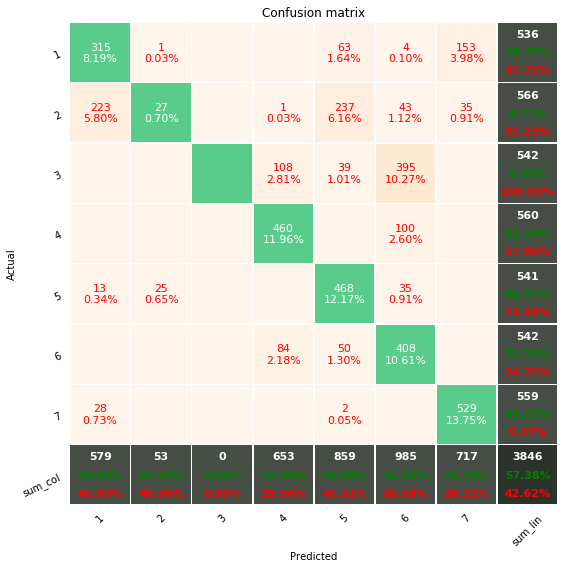

In [20]:
pretty_plot_confusion_matrix(confusion.transpose())

## Feature importance

Now, we want to select some features and then apply the random forest classifier to see how well it perform  when we only use some of the most important features.


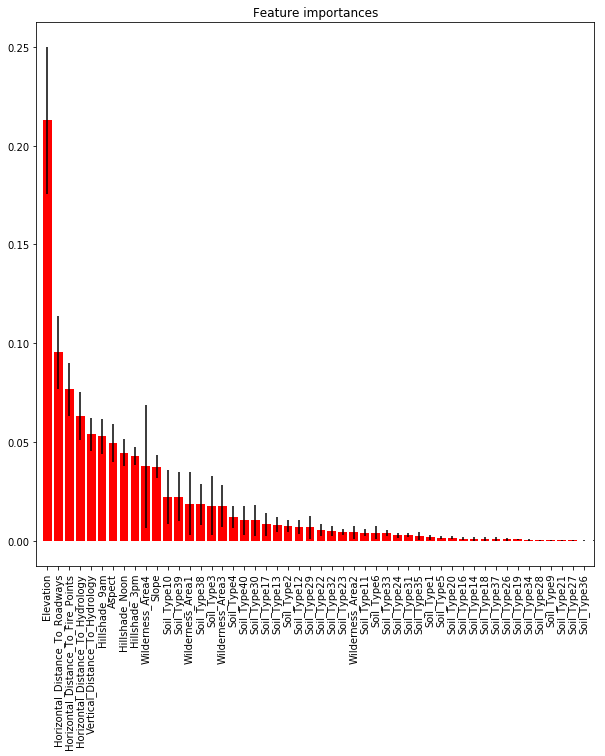

In [21]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
labels=[]
for i in indices:
    labels.append(feat_labels[i])
plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(50), labels, rotation='vertical')
plt.xlim([-1, 50])
plt.show()


Using the graph above, We choose only 15 of the 50 features which are listed below:

In [22]:
chosen_fea = labels[0:15]
chosen_fea

['Elevation',
 'Horizontal_Distance_To_Roadways',
 'Horizontal_Distance_To_Fire_Points',
 'Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Hillshade_9am',
 'Aspect',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Wilderness_Area4',
 'Slope',
 'Soil_Type10',
 'Soil_Type39',
 'Wilderness_Area1',
 'Soil_Type38']

Now, let's train the data for  the choosen features using  random forest classifier.


In [23]:
model = RandomForestClassifier(n_estimators=n_estimators,random_state=0,n_jobs=-1)
model = model.fit(x_train[chosen_fea],y_train)
y_pred = model.predict(x_test[chosen_fea])
accuracy1 = accuracy_score(y_test,y_pred)

In [45]:
accuracy1

0.8484139365574623

By choosing only %30 of the features, the accuracy went down by approximately:

In [24]:
(accuracy-accuracy1)*100

2.6781071242849785

In [25]:
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=range(1,8), index=range(1,8))

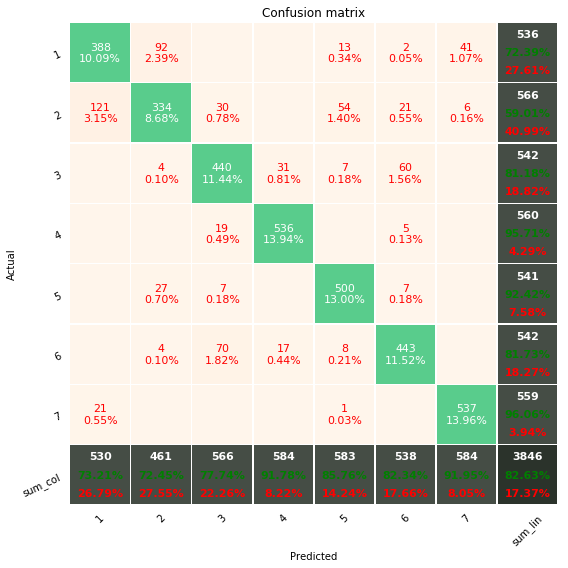

In [26]:
pretty_plot_confusion_matrix(confusion.transpose())

As we see above:
- more than 1 percent of class 2 are prediced to be of class 1 and 5
- more than 1 percent of class 1 are prediced to be of class 2 and 7
- more than 1 percent of class 6 are prediced to be of class 3
- more than 1 percent of class 3 are prediced to be of class 6


Let's do feature importance again. It may change, if we have dropped 70 pecent of the features.

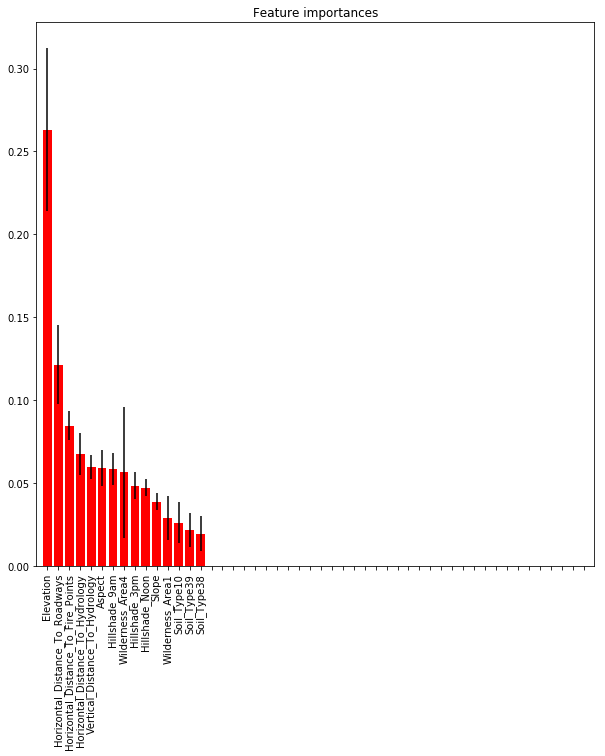

In [27]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
labels=[]
for i in indices:
    labels.append(chosen_fea[i])
plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.bar(range(x_train[chosen_fea].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(50), labels, rotation='vertical')
plt.xlim([-1, 50])
plt.show()


##  Hyper Parameter Tuning

We first do random search hyperparameter tuning for all the parameters except the number of trees: n_estimators

The default parameters of random forest classifier are as follows:

'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False

The number of leaf nodes is at most $2^n$ where $n$ is the number of observations on the data.
Therefore, max_depth is at most $log_2 n$+1

In [28]:
max_max_depth = int(math.log(x_train.shape[0],2))+1
max_max_depth

14

Now, we use Random search cross validation method for hyper parameter tuning

In [29]:
rf = RandomForestClassifier(n_estimators = n_estimators, n_jobs = -1,random_state=0) 

param_grid = { 
    'max_features' : ['sqrt', 'log2'],
    "min_samples_split": [2,3,5,7,9],
    "min_samples_leaf": np.arange(1,60,5),
     'max_depth' : [1,2,4,8,max_max_depth,None]
     }
CV_rf = RandomizedSearchCV(estimator=rf, param_distributions =param_grid, n_jobs = -1, cv= 10, n_iter = 100, 
                            random_state=0)
CV_rf.fit(x_train[chosen_fea], y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 3, 5, 7, 9], 'min_samples_leaf': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56]), 'max_depth': [1, 2, 4, 8, 14, None]},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [30]:
best_params = CV_rf.best_params_
best_params

{'min_samples_split': 7,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None}

In [31]:
y_pred = CV_rf.predict(x_test[chosen_fea])


In [32]:
accuracy_score(y_test,y_pred)

0.8341133645345814

In [33]:
confusion =pd.DataFrame(confusion_matrix(y_test, y_pred), columns=range(1,8), index=range(1,8))

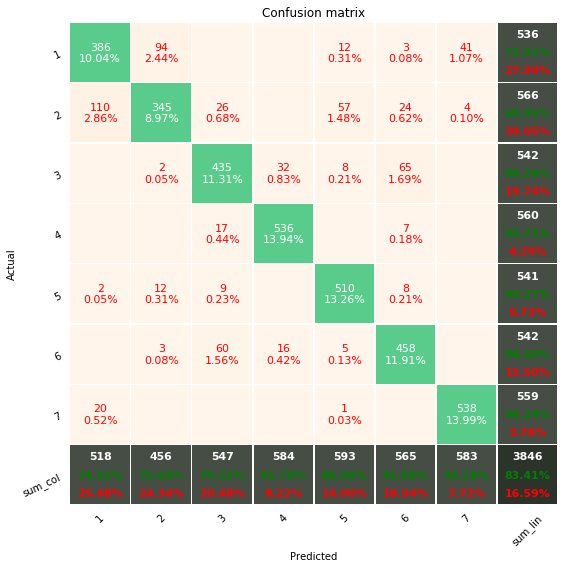

In [34]:
pretty_plot_confusion_matrix(confusion.transpose())

In [35]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [36]:
#the top 3 models
report(CV_rf.cv_results_)

Model with rank: 1
Mean validation score: 0.837 (std: 0.006)
Parameters: {'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}

Model with rank: 2
Mean validation score: 0.830 (std: 0.009)
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 14}

Model with rank: 3
Mean validation score: 0.817 (std: 0.011)
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'log2', 'max_depth': None}

Model with rank: 3
Mean validation score: 0.817 (std: 0.011)
Parameters: {'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': None}

Model with rank: 3
Mean validation score: 0.817 (std: 0.011)
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'log2', 'max_depth': None}



Now, we do hyperparameter tuning for the number of trees:

In [37]:
rf=RandomForestClassifier(**best_params, oob_score=True,n_jobs=-1,random_state=0)
accuracy = []
for i in range(30,300):
    clone(rf)
    rf.n_estimators=i
    rf.fit(x_train[chosen_fea],y_train)
    accuracy.append(rf.oob_score_)
    

the maximum accuracy for the decision trees from 20 to 300 occurs when the number of decision trees is:

In [38]:
n_trees = np.argmax(accuracy)
n_trees


225

The maximum accuracy obtained is 

In [39]:
max(accuracy)


0.8537996489631411

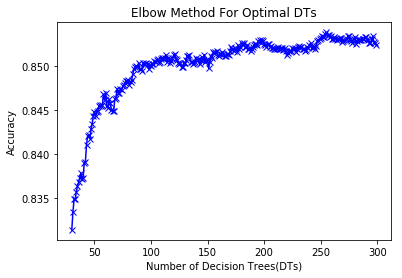

In [40]:
 plt.plot(range(30,300), accuracy[0:270], 'bx-')
plt.xlabel('Number of Decision Trees(DTs)')
plt.ylabel('Accuracy')
plt.title('Elbow Method For Optimal DTs')
plt.show()

In [41]:
best_params['n_estimators'] = n_trees

In [42]:
best_params

{'min_samples_split': 7,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None,
 'n_estimators': 225}

In [43]:
rf=RandomForestClassifier(**best_params,n_jobs=-1,random_state=0)

In [44]:
rf.fit(x_train[chosen_fea],y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=7,
            min_weight_fraction_leaf=0.0, n_estimators=225, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Let's see the result on the unseen data.

In [45]:
y_pred = rf.predict(x_test[chosen_fea])

In [46]:
accuracy_score(y_pred,y_test)

0.8411336453458138

In [47]:
confusion =pd.DataFrame(confusion_matrix(y_test, y_pred), columns=range(1,8), index=range(1,8))

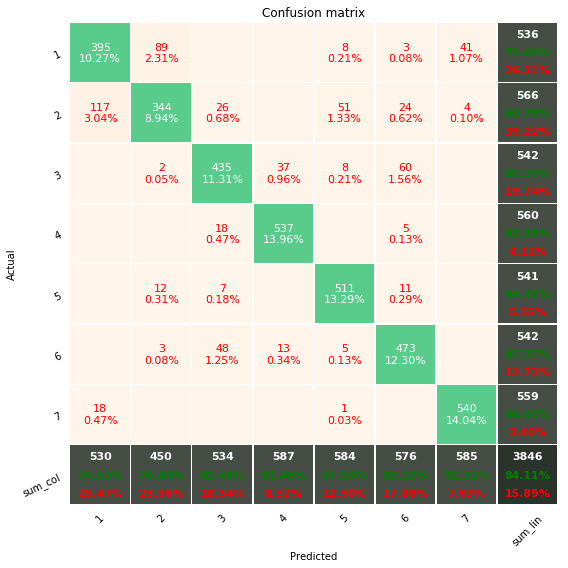

In [48]:
pretty_plot_confusion_matrix(confusion.transpose())